# an Overall code for CF and head views analysis for all csvs

imports

In [532]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import openpyxl
import os
import re
import ggplot


parameters

experiments_folder: the folder with all the experiments we want to plot and make csvs for

regex: the text we take from logs in each results to extract the threshold

plot_kwards: the args for the results plot

save..: if we want to save the plot/csv data of the results

plot folder:dest path to save the plots

mean_std_folder: dest path to csv data

In [533]:
experiments_folder = Path('/home/administrator/experiments/')
regex =' (.*) threshold\\nlayer\s*\\n(\d*)(\s+)(\d*.\d*)(\s+)(\d*.\d*)\\n(\d*)(\s+)(\d*.\d*)(\s+)(\d*.\d*)\\n(\d*)(\s+)(\d*.\d*)(\s+)(\d*.\d*)'
plot_kwargs={'grid':True,'figsize':(20,8), 'fontsize':12}
save_views_plot = 0
save_cf_plot = 0
save_views_csv = 1
save_cf_csv = 1
plots_folder = ''
mean_std_folder=''

make the csvs list

In [534]:
# for experiment in experiments_folder.iterdir():
#     csv_path = (str(experiment)+'/vgg/results/comparisons_with_fc7_linear.csv')
#     csv_list.append(csv_path)
csv_list = ['/home/administrator/experiments/1000_ids_20_train/vgg16/results/comparisons_with_fc7_linear.csv']

    results of the threshold extraction:
    results.group(2) = 38
    results.group(4) = accuracy (38) 
    results.group(6) = threshold (38)
    
    results.group(7) = 37
    results.group(9) = accuracy (37) 
    results.group(11) = threshold (37)
    
    results.group(12) = 39
    results.group(14) = accuracy (39) 
    results.group(16) = threshold (39)

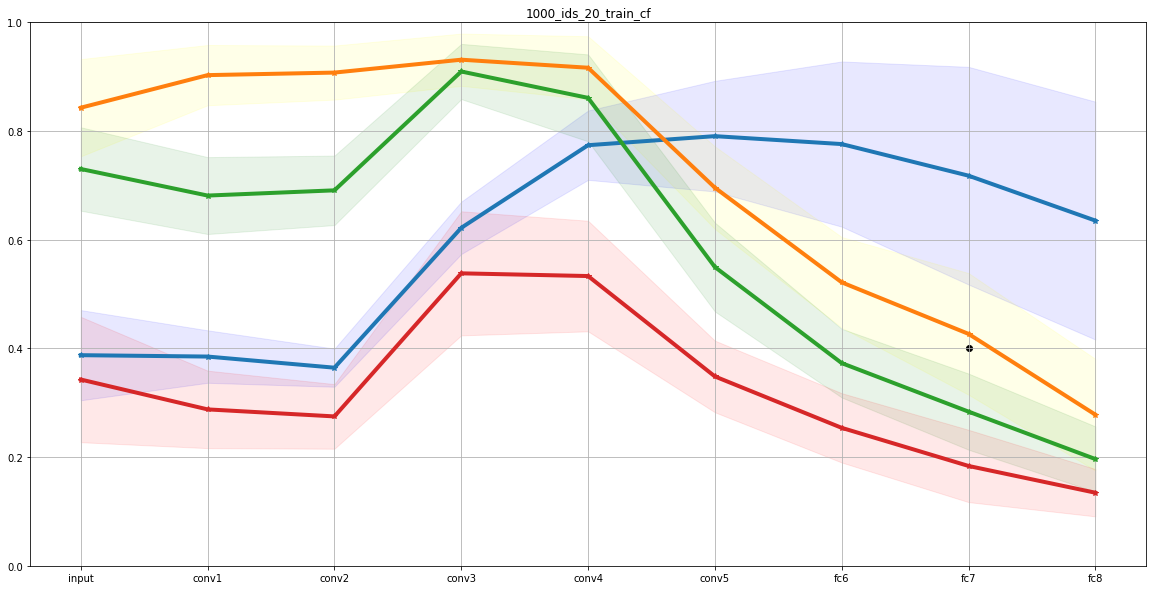

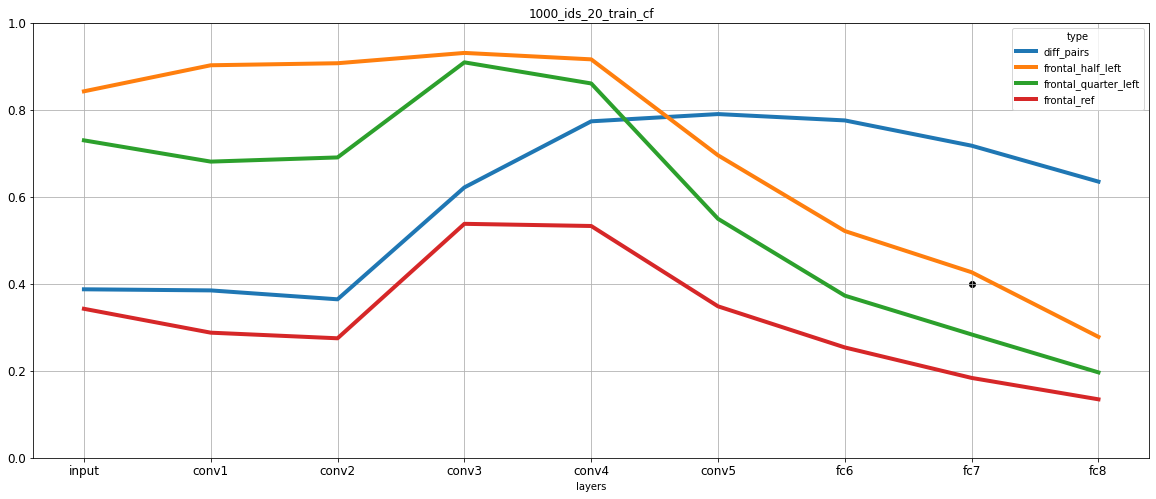

In [535]:
for csv_file in csv_list:
    df = pd.read_csv(csv_file)
    splited = csv_file.split('/') 
    base_title = splited[splited.index('experiments')+1]
    p = Path(csv_file).parents[2]
    threshold_file = os.path.join(Path(csv_file).parents[2], 'logs')
    #extract threshold
    with open(threshold_file) as fo:
        logs = fo.read()
        results = re.search(regex,logs)
        threshold37 = float(results.group(11)) 
    
    # change unnamed column to 'pairs'
    df = df.rename(columns = {'Unnamed: 0':'pairs'})
    
    #split the tuples to two columns
    df_splited = df['pairs'].str.split(',', expand=True)

    #adding   
    df.insert(loc=0, column='img1', value=df_splited[0] )
    df.insert(loc=1, column='img2', value=df_splited[1] )


    # Dropping old Name columns 
    df.drop(columns =["pairs"], inplace = True) 
    
    #reorder columns by layer order
    df = df[['img1', 'img2', 'input', 'conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8','type' ]]


    ##################head views###################
    
    title = base_title +'_views'

    #change frontal-ref to frontal_ref
    df['type'] = df['type'].replace(['frontal-ref'],'frontal_ref')


    #change frontal-quarter_left to frontal_quarter_left
    df['type'] = df['type'].replace(['frontal-quarter_left'],'frontal_quarter_left')


    #change frontal-half_left to frontal_half_left
    df['type'] = df['type'].replace(['frontal-half_left'],'frontal_half_left')

    #remove  HPS,LPS,SAME type.
    # df = df[df.type.str.contains("same_pairs|frontal|diff_pairs")]
    df1 = df[df.type.str.contains("frontal|diff_pairs")]

    df2 = df1[df1.type.str.contains("same_pairs|diff_pairs")]
    # df1 = df[df['type'] =='diff_pairs'|df['type']=='same_pairs']
    df3 = df2[df2.img1.str.contains("CM")] 
    # df3 = df[df['type'] !='diff_pairs'&df['type'] !='same_pairs']
    df4 = df1[~df1.type.str.contains("same_pairs|diff_pairs")]

    df_views = pd.concat([df3,df4])
    df_views.reset_index()
    max_value_df = df_views.max()
    max_value_df
    df_views = df_views.reset_index(drop=True)
    
    df_views = df_views.drop(columns=['img1', 'img2'])
    normalized_treshold_views = threshold37/max_value_df['fc7']
    
    for x in df_views.drop(columns=['type']).columns:
        df_views[x]= (df_views[x]/df_views[x].max()) 
    
    
    #mean of each columns by type of pairs
    means_df = df_views.groupby(['type']).mean()
    means_df = means_df.rename_axis("layers", axis="columns")
    means_df = means_df.transpose()

    
    std = df_views.groupby(['type']).std()
    std = std.transpose()
    
    #combine means and std df to one:
    columns = means_df.columns.copy()
    rows =  means_df.index.copy()
    header = pd.MultiIndex.from_product([columns,
                                         ['mean','STD']],
                                        names=['type','mean/STD'])
    df_means_std = pd.DataFrame( 
                      index=rows, 
                      columns=header)

    df_means_std[('diff_pairs','mean')] = means_df.diff_pairs.copy()
    df_means_std[('diff_pairs','STD')] = std.diff_pairs.copy()
    
    df_means_std[('frontal_half_left','mean')] = means_df.frontal_half_left.copy()
    df_means_std[('frontal_half_left','STD')] = std.frontal_half_left.copy()
    
    df_means_std[('frontal_quarter_left','mean')] = means_df.frontal_quarter_left.copy()
    df_means_std[('frontal_quarter_left','STD')] = std.frontal_quarter_left.copy()
    
    df_means_std[('frontal_ref','mean')] = means_df.frontal_ref.copy()
    df_means_std[('frontal_ref','STD')] = std.frontal_ref.copy()
    
    
        #save to csv/excel
    if (save_views_csv == 1):
        df_means_std.to_csv(mean_std_folder+title)
        # df.to_excel("output.xlsx", sheet_name='Sheet_name_1')  

    
#     #plot
#     plot = means_df.plot(**plot_kwargs, title = title, ylim = [0,1], lw=4)
#     plt.scatter(7, normalized_treshold_views, color='black')
    
#     #save plot
#     if (save_views_plot==1):
#         plt.savefig(plots_folder+title)
    



    
    #################critical features#################
    title = base_title +'_cf'
    
    #remove all last rows - save only DIFF,HPS,LPS,SAME type.
    df_cf = df[~df.type.str.contains("frontal")]
    
    #max values df
    max_value_df = df_cf.max()
    
    df_cf = df_cf.reset_index(drop=True)
    df_cf = df_cf.drop(columns=['img1', 'img2'])
    
    #normalized threshold
    normalized_threshold_cf = threshold37/max_value_df['fc7']
    
    #
    for x in df_cf.drop(columns=['type']).columns:
        df_cf[x]= (df_cf[x]/df_cf[x].max()) 
    
    
    #mean of each columns by type of pairs
    means_df_cf = df_cf.groupby(['type']).mean()
    means_df_cf = means_df_cf.rename_axis("layers", axis="columns")
    means_df_cf = means_df_cf.transpose()
    
    std_cf = df_cf.groupby(['type']).std()
    std_cf = std_cf.transpose()
    
    #combine means and std df to one:
    columns_cf = means_df_cf.columns.copy()
    rows_cf =  means_df_cf.index.copy()
    header_cf = pd.MultiIndex.from_product([columns_cf,
                                         ['mean','STD']],
                                        names=['type','mean/STD'])
    df_means_std_cf = pd.DataFrame( 
                      index=rows_cf, 
                      columns=header_cf)

    df_means_std_cf[('diff_pairs','mean')] = means_df_cf.diff_pairs.copy()
    df_means_std_cf[('diff_pairs','STD')] = std_cf.diff_pairs.copy()
    
    df_means_std_cf[('high_ps_pairs','mean')] = means_df_cf.high_ps_pairs.copy()
    df_means_std_cf[('high_ps_pairs','STD')] = std_cf.high_ps_pairs.copy()
    
    df_means_std_cf[('low_ps_pairs','mean')] = means_df_cf.low_ps_pairs.copy()
    df_means_std_cf[('low_ps_pairs','STD')] = std_cf.low_ps_pairs.copy()
    
    df_means_std_cf[('same_pairs','mean')] = means_df_cf.same_pairs.copy()
    df_means_std_cf[('same_pairs','STD')] = std_cf.same_pairs.copy()
    
    
    #save to csv/excel
    if (save_cf_csv == 1):
        df_means_std_cf.to_csv(mean_std_folder+title)
        # df.to_excel("output.xlsx", sheet_name='Sheet_name_1')  

    #plot
#     fig, ax = plt.subplots(figsize=(16, 12))

    score_lower_limit = means_df - std
    score_upper_limit = means_df + std
    COLORS = "blue", "yellow", "green", "red"

    
    param_fig, param_ax = plt.subplots(sharex = 'all', figsize=(20,10))
    plt.ylim(0, 1)
    param_ax.set_title(title)
    param_ax.plot(means_df, marker='*', lw=4)
    for i, col in enumerate(means_df.columns):
            param_ax.fill_between(means_df.index,
                              score_lower_limit[col],
                              score_upper_limit[col],
                              color=COLORS[i],
                              alpha=0.09)
    param_ax.scatter(7, normalized_threshold_cf, color='black')
    param_ax.grid()

        
    #     plt.plot(score_lower_limit)
#     plt.plot(score_upper_limit)


#     plt.subplots(means_df)
    plt = means_df.plot(**plot_kwargs, title = title, ylim = [0,1], lw=4)
    plt.scatter(7, normalized_threshold_cf, color='black')
#     param_ax.set_ylable("y")
 ##########ggplot tests:###############
#     for i, (key, grp) in enumerate(means_df):
#         grp.plot(kind="line",
#                  x="Number of Estimators",
#                  y="Mean Test Score",
#                  color=COLORS[i],
#                  label=str(key),
#                  ax=param_ax)
#         score_mean = grp["Mean Test Score"]
#         score_std = grp["Test Score STD"]
#         score_lower_limit = score_mean - score_std
#         score_upper_limit = score_mean + score_std
#         param_ax.fill_between(N_ESTIMATORS,
#                               score_lower_limit,
#                               score_upper_limit,
#                               color=COLORS[i],
#                               alpha=0.1)
#     param_ax.set_ylabel("Accuracy")
# #     param_ax.scatter(model_searcher.best_params_["n_estimators"],
# #                      model_searcher.best_score_,
# #                      marker="*",
# #                      color="black",
# #                      s=150,
# #                      label="Selected Model")
# #     _ = param_ax.legend()

# #     import ggplot as gg

# #     plot = gg.plt
# #     gg.qplot(plot.wt, plot.mpg) + gg.geom_smooth(color="blue")

    
    
##############################################
    #save plot
    if (save_cf_plot==1):
        plt.savefig(plots_folder+title)


In [536]:

score_lower_limit = means_df - std
score_upper_limit = means_df + std
print(score_lower_limit)
print(score_upper_limit )

type    diff_pairs  frontal_half_left  frontal_quarter_left  frontal_ref
layers                                                                  
input     0.304526           0.753278              0.653243     0.227358
conv1     0.336665           0.847223              0.610334     0.216458
conv2     0.329393           0.857586              0.626806     0.215394
conv3     0.573560           0.882955              0.858541     0.423893
conv4     0.709964           0.858308              0.780848     0.431313
conv5     0.688643           0.619651              0.467849     0.282420
fc6       0.623858           0.438026              0.309684     0.190014
fc7       0.517454           0.314761              0.213597     0.117169
fc8       0.416206           0.175421              0.136331     0.090928
type    diff_pairs  frontal_half_left  frontal_quarter_left  frontal_ref
layers                                                                  
input     0.470409           0.932139              

In [537]:
std

type,diff_pairs,frontal_half_left,frontal_quarter_left,frontal_ref
input,0.082942,0.089431,0.076726,0.115301
conv1,0.048254,0.055416,0.070738,0.071263
conv2,0.035051,0.049720,0.063900,0.059419
conv3,0.048158,0.048068,0.050782,0.114130
conv4,0.063773,0.057931,0.079950,0.101723
conv5,0.101747,0.075950,0.081730,0.065893
fc6,0.151949,0.083405,0.063165,0.063756
fc7,0.200204,0.111860,0.069998,0.066497
fc8,0.218828,0.102621,0.060058,0.043525
